In [25]:
import matplotlib.pyplot as plt
import numpy as np
#v. 20220811.1
filedir = './data/'
outputdir = './output/'
filenames = ['CARAS65 .ELH']
fs = 500                        # частота дискретизации, Гц
signal_scale = 500              # коэффициент масштабирования сигнала
signal_unit = 'µV'              # единица измерения сигнала
first_stim_start_time = 1       # начало первого стимула, с
period = 5                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 90        # длительность фоновой засветки, с
sign = 1                        # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
low_cutoff = 0.1                # частота среза highpass фильтра, Гц
stim_maximums_to_delete = []    # номера неудачных стимулов (перечислить через запятую)
stims_to_export = []            # номера стимулов для экспорта в файл (пример: [(0, 2), 25] - с 0 по 2, 25)
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [26]:
# Чтение сигнала из файла(ов)
signal = []
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
        for line in file:
            signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
signal = np.array(signal)

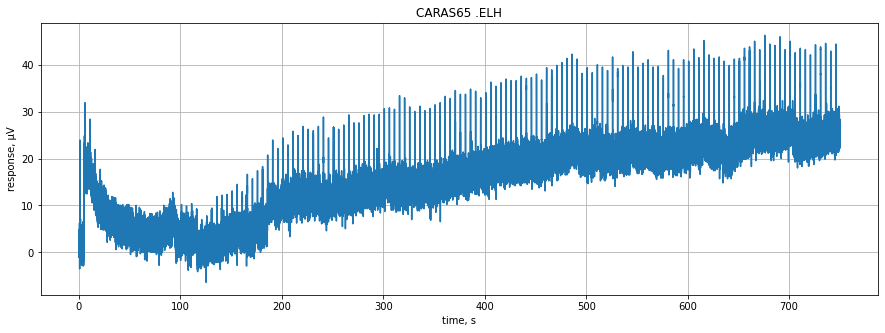

In [27]:
# Построение графика сигнала
n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(','.join(filenames))
ax.grid()

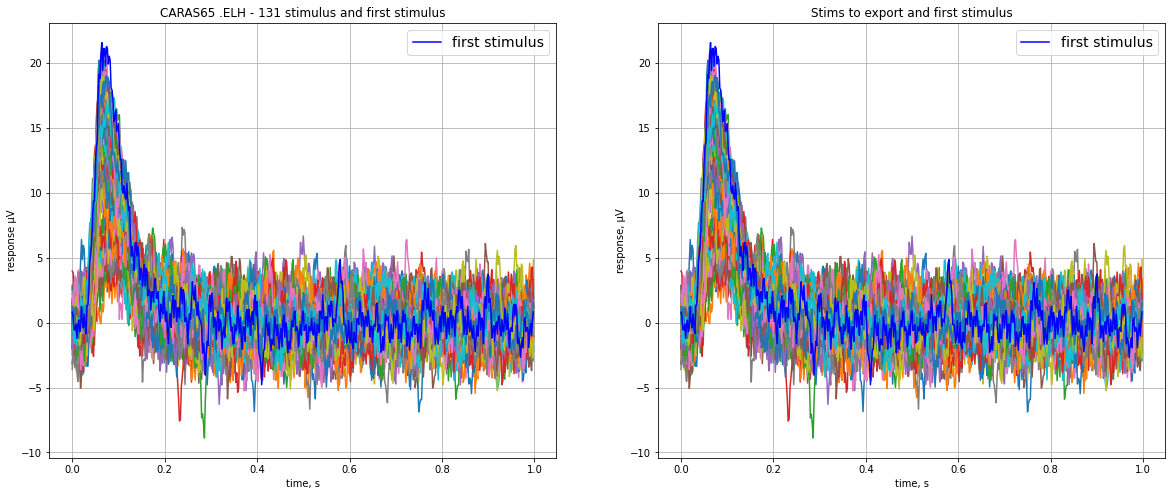

In [28]:
stims_cnt = ((n - 1) // fs - after_background_start_time) // period + 1
stims = []
prefix = fs // 5 # 0.2 секунды слева от стимула используются для расчета тренда
postfix = fs // 5 # последние 0.2 секунды стимула используются для расчета тренда
size = fs + prefix

# вычитание тренда из стимулов
for i in range(stims_cnt):
    begin = after_background_start_time * fs + period * i * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stim = stim[prefix:]
    stims.append(stim)

# вычитание тренда из первого стимула
begin = first_stim_start_time * fs - prefix
end = begin + size
first_stim = np.array(signal[begin:end])
temp_t = np.linspace(0, (size - 1), size)
x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
y = np.concatenate([first_stim[:prefix], first_stim[size - postfix:]])
s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
k, b = s[1], s[0]
trend = k * temp_t + b
first_stim = first_stim - trend
first_stim = first_stim[prefix:]
first_stim_max = first_stim.max()

size -= prefix
temp_t = np.linspace(0, 1 - 1 / fs, size)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
for stim in stims:
    ax1.plot(temp_t, stim)
ax1.plot(temp_t, first_stim, 'b', label='first stimulus')
ax1.legend(prop={"size": 14})
ax1.set_xlabel('time, s')
ax1.set_ylabel('response ' + signal_unit)
ax1.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus and first stimulus')
ax1.grid()

numbers = set()
if not stims_to_export:
    numbers = set(range(stims_cnt))
else:
    for number in stims_to_export:
        if type(number) is tuple:
            numbers |= set(range(number[0], number[1] + 1))
        else:
            numbers.add(number)
stims_to_export = list(sorted(numbers))
for number in stims_to_export:
    ax2.plot(temp_t, stims[number])
ax2.plot(temp_t, first_stim, 'b', label='first stimulus')
ax2.legend(prop={"size": 14})
ax2.set_xlabel('time, s')
ax2.set_ylabel('response, ' + signal_unit)
ax2.set_title('Stims to export and first stimulus')
ax2.grid()

In [29]:
# Аппроксимация максимумов стимулов экспонентой
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stim_maximums = np.array([stim.max() for stim in stims])

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# График максимумов стимулов начинает строится в точке, равной рассчитанному расстоянию
begin = after_background_start_time - background_start_time - background_duration
end = begin + (stims_cnt - 1) * period
stim_maximums_x = np.linspace(begin, end, stims_cnt)

print('Номер\tВремя\tМаксимум')
for i, (x, stim_maximum) in enumerate(zip(stim_maximums_x, stim_maximums)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}')

Номер	Время	Максимум
0	1.0	6.6140
1	6.0	6.7402
2	11.0	6.0858
3	16.0	6.7533
4	21.0	6.6620
5	26.0	6.0386
6	31.0	6.7300
7	36.0	6.9756
8	41.0	9.5975
9	46.0	9.1517
10	51.0	9.0696
11	56.0	9.5106
12	61.0	10.5161
13	66.0	8.1567
14	71.0	12.6146
15	76.0	11.8006
16	81.0	12.0395
17	86.0	13.1099
18	91.0	11.1612
19	96.0	13.1946
20	101.0	12.7548
21	106.0	12.8695
22	111.0	12.1945
23	116.0	14.3853
24	121.0	13.0212
25	126.0	14.6904
26	131.0	14.1483
27	136.0	13.8024
28	141.0	14.4495
29	146.0	17.9244
30	151.0	13.2085
31	156.0	14.0379
32	161.0	15.2045
33	166.0	14.4999
34	171.0	16.4461
35	176.0	14.3518
36	181.0	14.6027
37	186.0	15.8181
38	191.0	15.3994
39	196.0	16.1955
40	201.0	15.8179
41	206.0	16.0694
42	211.0	15.8204
43	216.0	16.5391
44	221.0	20.0458
45	226.0	19.1033
46	231.0	17.3216
47	236.0	15.4464
48	241.0	17.3213
49	246.0	15.4576
50	251.0	16.3935
51	256.0	17.8529
52	261.0	16.6058
53	266.0	18.2680
54	271.0	16.6744
55	276.0	18.4395
56	281.0	17.0697
57	286.0	17.9227
58	291.0	18.0219
59	296.0	17.0384
60	3

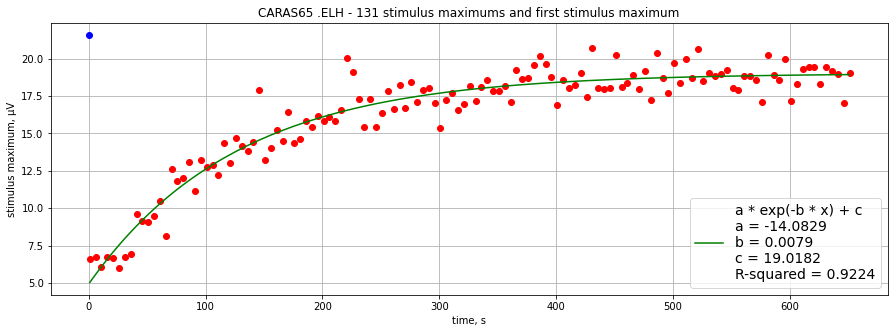

In [30]:
# Удаление неудачных максимумов стимулов
stim_maximums = np.delete(stim_maximums, stim_maximums_to_delete)
stim_maximums_x = np.delete(stim_maximums_x, stim_maximums_to_delete)

popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stim_maximums_x, stim_maximums, [-10, 0.01, 10])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stim_maximums_x, *popt)
rvalue = stats.linregress(stim_maximums, fit).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(stim_maximums_x, stim_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stim_maximums_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - {stim_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

In [31]:
# Сохранение результатов в файлы
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
# Сохранение максимумов стимулов
with open(f'{outputdir}{",".join(filenames)}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stim_maximums.size):
        file.write(f'{stim_maximums_x[i]}\t{stim_maximums[i]}\t{fit[i]}\n')

# Сохранение стимулов
with open(f'{outputdir}{",".join(filenames)}_resp.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write('time, с\tОпорный\t')
    for number in stims_to_export:
        file.write(f'{number}\t')
    file.write('\n')
    size = first_stim.size
    temp_t = np.linspace(0, 1 - 1 / fs, size)
    for i in range(size):
        file.write(f'{temp_t[i]:.4f}\t{first_stim[i]}\t')
        for number in stims_to_export:
            file.write(f'{stims[number][i]}\t')
        file.write('\n')

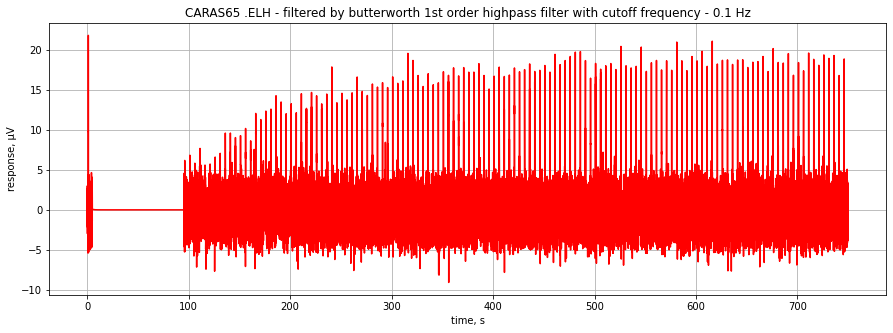

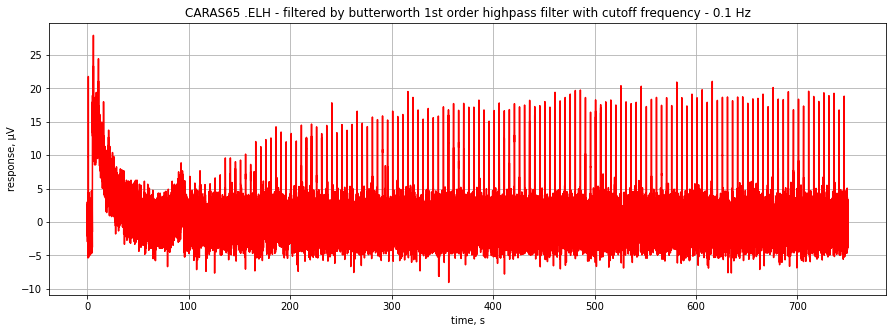

In [32]:
# Следующий блок кода используется только в целях красивого построения графика сигнала, отфильтрованного highpass фильтром Баттерворта.
# В расчетах максимумов стимулов и экспоненты отфильтрованный сигнал не участвует,
# так как фильтр немного обрезает максимум стимулов и добавляет отрицательный зубец на нисходящем фронте стимула

# Смещение сигнала до начала фона к 0
signal[:background_start_time * fs] -= signal[:first_stim_start_time * fs].mean()
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
# Копия фона - необходима, чтобы его потом нарисовать вместе с отфильтрованным сигналом
background = np.array(signal[begin:end])
# Смещение сигнала после окончания фона к 0
signal[end:] -= signal[end:after_background_start_time * fs].mean()
# Удаление фона, для того чтобы избежать переходного процесса фильтра после него и измерить высоту первого после него стимула
signal[begin:end] = 0

from scipy.signal import butter, lfilter
nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()

# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = background - background[0]
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()